### Detector Systematics 
- Load the DetVar samples, applies the nue selection on them
- The after selection pickl is used to study the variations

-- efficieny at different stages

-- in function of a variable (plot)

In [1]:
import nue_selection_helper as nue_helper
from helpers import helpfunction as helper
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
data = pd.read_pickle('./input/July2020/lite/after_training.pckl')

In [3]:
data = data['nu']

In [6]:
list(data['daughters'].keys())

['backtracked_pz',
 'backtracked_px',
 'backtracked_py',
 'shr_tkfit_dedx_y_v',
 'shr_theta_v',
 'trk_sce_end_x_v',
 'shr_phi_v',
 'trk_llr_pid_score_v',
 'contained_fraction',
 'trk_distance_v',
 'backtracked_start_x',
 'pfp_trk_daughters_v',
 'shr_tkfit_dedx_nhits_y_v',
 'topological_score',
 'backtracked_e',
 'ismerged',
 'hits_ratio',
 'run',
 'backtracked_start_y',
 'shr_dist_v',
 'backtracked_completeness',
 'n_showers',
 'merge_bestdot',
 'shr_tkfit_gap10_dedx_y_v',
 'reco_nu_vtx_y',
 'CosmicIPAll3D',
 'trk_sce_start_x_v',
 'trk_len_v',
 'backtracked_purity',
 'n_showers_contained',
 'trk_score_v',
 'n_pfps',
 'trk_sce_end_y_v',
 'pfp_generation_v',
 'secondshower_Y_nhit',
 'sub',
 'trk_theta_v',
 'shr_tkfit_2cm_dedx_Y',
 'backtracked_start_z',
 'CosmicDirAll3D',
 'trk_sce_start_z_v',
 'shr_tkfit_nhits_v',
 'reco_nu_vtx_sce_x',
 'trk_sce_end_z_v',
 'trk_sce_start_y_v',
 'pfp_shr_daughters_v',
 'pfnhits',
 'reco_nu_vtx_sce_z',
 'n_tracks_contained',
 'merge_bestdist',
 'reco_nu_v

In [9]:
values = data['daughters'].xs(0, level='daughter')['shr_tkfit_dedx_y_v']
cv_weights = data['daughters'].xs(0, level='daughter')['weightSplineTimesTune']
genie_weights = data['mc']['weightsGenie']
assert(len(genie_weights) == len(cv_weights))
x_min = 0
x_max = 10
n_bins = 20

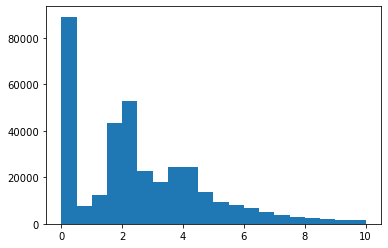

In [11]:
_ = plt.hist(values, range=(x_min,x_max), bins=n_bins, weights=cv_weights)

In [12]:
index = values[values.between(7.453,7.4532)].index[0]
dedx = values[index]
row_nr = np.where(values==dedx)[0]
#genie_weights[row_nr

In [26]:
# indexes with abnormal weights:
bad_weights_index = np.where(np.mean(genie_weights, axis=1)>10)[0]
data['daughters'].xs(0, level='daughter')['category'][bad_weights_index].value_counts()

2     80
5     31
11    30
4     15
3      6
10     2
Name: category, dtype: int64

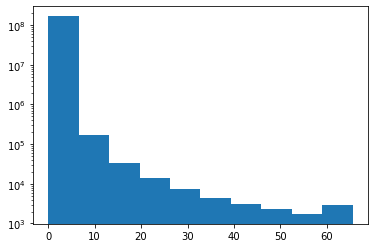

In [8]:
plt.hist(genie_weights.flatten())
plt.yscale('log')

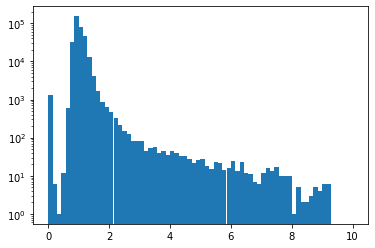

In [9]:
genie_weights[np.where(genie_weights>20)]=1
plt.hist(np.mean(genie_weights, axis=1), bins=70, range=(0,10))
plt.yscale('log')

In [12]:
genie_weights[row_nr].mean()

7.848

In [12]:
def cov_nonvec(values, cv_weights, weights, x_min, x_max, n_bins):
    start = time.time()
    n_cv, bin_edges = np.histogram(values, weights=cv_weights, range=(x_min,x_max), bins=n_bins)
    n_uni = weights.shape[1]
    cov_this = np.zeros([n_bins, n_bins])
    print(bin_edges)
    print(n_cv)

    n_uni=1000

    weights = np.multiply(weights,cv_weights[:, np.newaxis])
    for i in range(n_uni):
        n, _ = np.histogram(values, weights=weights.T[i], bins=bin_edges,)
        cov_this += np.outer(n - n_cv, n - n_cv)

    end = time.time()
    print("mean fractional error", np.mean(np.sqrt(np.diag(cov_this / n_uni)) / n_cv))
    print('time passed: {:.1f}s.'.format(end-start))

In [13]:
def cov_halfvec(values, cv_weights, weights, x_min, x_max, n_bins):
    start = time.time()
    n_cv, bin_edges = np.histogram(values, weights=cv_weights, range=(x_min,x_max), bins=n_bins)
    binning = np.digitize(values, bin_edges)-1
    weights = np.multiply(weights,cv_weights[:, np.newaxis])
    n_uni = weights.shape[1]
    n = np.empty((n_bins, n_uni))
    cov_this = np.zeros([n_bins, n_bins])
    for i in range(n_bins):
        n[i] = np.sum(np.multiply(weights,np.array(binning==i)[:, np.newaxis]),axis=0)
    for k in range(n_uni):
        cov_this += np.outer(n.T[k] - n_cv, n.T[k] - n_cv)

    end = time.time()
    print("mean fractional error", np.mean(np.sqrt(np.diag(cov_this / n_uni)) / n_cv))
    print('time passed: {:.1f}s.'.format(end-start))
    return np.sqrt(np.diag(cov_this / n_uni)) / n_cv
fraq_err_bin = cov_halfvec(values, cv_weights, genie_weights, x_min, x_max, n_bins)

mean fractional error 0.3416525299687017
time passed: 9.1s.


In [14]:
fraq_err_bin

array([0.29333963, 0.48008225, 0.39033817, 0.30756134, 0.28158052,
       0.38891465, 0.27898681, 0.25022257, 0.28743682, 0.26201581,
       0.45974114, 0.41220412, 0.43394747, 0.46187638, 0.33593721,
       0.36270375, 0.41802881, 0.22410358, 0.30060878, 0.2034208 ])

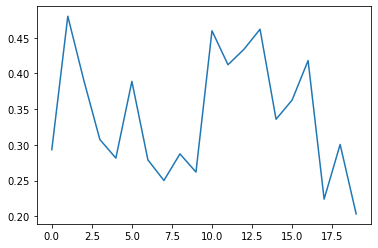

In [15]:
plt.plot(fraq_err_bin)

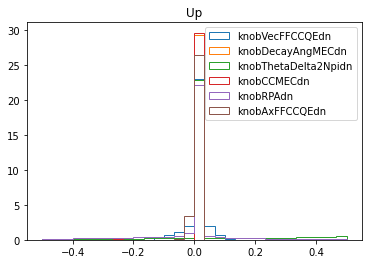

In [8]:
for k in knobs:
    up_weights = np.clip(np.nan_to_num(data['mc'][k], nan=1, posinf=1, neginf=1),0,20)
    up_weights = np.where(up_weights!=0, up_weights, 1)
    k = k.replace('up','dn')
    down_weights = np.clip(np.nan_to_num(data['mc'][k], nan=1, posinf=1, neginf=1),0,20)
    down_weights = np.where(down_weights!=0, down_weights, 1)
    plt.hist(up_weights-down_weights, range=(-0.5,0.5), bins=30, density=1, label=k, histtype='step')
plt.legend()
plt.title('Up')
plt.show()

In [5]:
write_pickle = False
outfile = './input/Jun2020/lite/sys_after_training.pckl'
input_dir = "./input/Jun2020/syst/"
output_dir = "./output/"

In [3]:
samples = ['_'.join(f.split('/')[-1].split('.')[0].split('_')[:-1]) for f in glob.glob(input_dir+'*.pckl')]

In [4]:
if write_pickle:
    nue_helper.CreateAfterTraining(samples, input_dir, one_file=outfile)
data = pd.read_pickle(outfile)

In [5]:
data.keys()

dict_keys(['nue_DetVar_WireModAngleYZ', 'nue_DetVar_LYRayleigh', 'nue_DetVar_LYAttenuation', 'nue_DetVar_wiremod_ScaleYZ', 'nue_DetVar_LYDown', 'nue_DetVar_wiremod_ScaledEdX', 'nue_DetVar_WireModAngleXZ', 'nue_DetVar_CV', 'nue_DetVar_wiremod_ScaleX'])

In [6]:
# We grouped by 'event' was this a smart choice?
for sample in samples:
    assert len(np.unique(data[sample]['daughters'].xs(0, level='daughter').index)) == len(data[sample]['daughters'].xs(0, level='daughter').index)

In [27]:
for sample in samples:
    data[sample]['daughters']['nueccinc_new'] = data[sample]['daughters']['category'].isin([1,10,11])
    num_w = data[sample]['daughters'].eval('nueccinc*weightSplineTimesTune').xs(0, level='daughter')
    den_w = data[sample]['mc']['weightSplineTimesTune'][data[sample]['mc']['nueccinc']]
    print('{:<30}\t Efficiency: {:0.1%}+-{:0.1%}'.format(sample, *helper.effErr(num_w, den_w) ))

nue_DetVar_WireModAngleYZ     	 Efficiency: 84.2%+-0.2%
nue_DetVar_LYRayleigh         	 Efficiency: 84.1%+-0.2%
nue_DetVar_LYAttenuation      	 Efficiency: 83.8%+-0.2%
nue_DetVar_wiremod_ScaleYZ    	 Efficiency: 83.8%+-0.2%
nue_DetVar_LYDown             	 Efficiency: 84.6%+-0.2%
nue_DetVar_wiremod_ScaledEdX  	 Efficiency: 83.6%+-0.2%
nue_DetVar_WireModAngleXZ     	 Efficiency: 84.0%+-0.2%
nue_DetVar_CV                 	 Efficiency: 84.1%+-0.2%
nue_DetVar_wiremod_ScaleX     	 Efficiency: 83.8%+-0.2%
